THIS IS A DEMO OF THE PROPOSED IDPS FOR MY MASTER THESIS

In [ ]:
!pip install pandas numpy scikit-learn pyod matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.3-py3-none-any.whl size=200466 sha256=68c0351e6a794076bbb27cf32b2d98a8f4f9a8cbf9be5c62711ce87be002abc9
  Stored in directory: /root/.cache/pip/wheels/2d/60/5b/f74eccd2c9c892a2c298202ca510f10995f9940647fcc2d97f
Successfully built pyod


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from pyod.models.sod import SOD  # Subspace Outlier Detection
from sklearn.neighbors import LocalOutlierFactor  # LOF
import matplotlib.pyplot as plt

Step 1: Preprocess Data

In [ ]:
# Load all datasets
normal_data = pd.read_csv('/content/drive/MyDrive/CWDS_DEMO/BATADAL Datasets/BATADAL_normal.csv')
train_data = pd.read_csv('/content/drive/MyDrive/CWDS_DEMO/BATADAL Datasets/BATADAL_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/CWDS_DEMO/BATADAL Datasets/BATADAL_test.csv')

In [ ]:
normal_data.head()

,DATETIME,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
0,06/01/14 00,0.509730,2.049003,3.191145,2.792634,2.656091,5.316831,1.562321,98.998444,1,...,87.605774,26.495605,84.206619,18.901676,81.983734,18.791777,67.125603,29.387470,28.487471,0
1,06/01/14 01,0.412580,2.009072,3.642565,2.831673,3.126387,5.494855,1.852043,99.095901,1,...,89.448341,26.487326,85.900085,18.849329,82.150589,18.739643,67.178696,29.354256,28.454256,0
2,06/01/14 02,0.320112,1.986093,4.140192,3.256733,3.574601,5.500000,2.246126,98.420959,1,...,91.056114,26.487364,86.582474,19.597170,83.988579,19.496712,72.425293,29.354538,28.454538,0
3,06/01/14 03,0.332879,2.009203,4.673478,3.744497,3.952379,5.500000,3.203573,97.575172,1,...,92.594353,26.575815,88.020546,26.028486,64.670486,25.922703,76.275040,29.449951,28.549952,0
4,06/01/14 04,0.483496,2.089049,5.237937,4.409456,3.504676,5.500000,4.439714,97.351059,1,...,94.473099,26.723457,90.422462,26.209970,64.746620,26.104692,76.703529,29.574265,28.674263,0


In [ ]:
# Combine "normal" and the normal parts of "train" for unsupervised training
normal_combined = pd.concat([
    normal_data,
    train_data[train_data['ATT_FLAG'] == 0]  # Normal segments of train
], ignore_index=True)

# Separate attack samples from train_data for supervised training
attack_samples = train_data[train_data['ATT_FLAG'] == 1]

Step 2: Train Unsupervised Models (LOF/SOD)

In [ ]:
# Normalize the combined normal data
scaler = StandardScaler()
X_normal = scaler.fit_transform(normal_combined.drop(['DATETIME', 'ATT_FLAG'], axis=1))

# Train SOD and LOF on pure normal data
sod = SOD(contamination=0.01)  # Assume very few outliers
sod.fit(X_normal)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)
lof.fit(X_normal)

LocalOutlierFactor(contamination=0.01, novelty=True)

Step 3: Train Supervised Model (QDA)

In [ ]:
# Prepare labeled data (train_data has attacks labeled)
X_train = scaler.transform(train_data.drop(['DATETIME', 'ATT_FLAG'], axis=1))
y_train = train_data['ATT_FLAG']

# Extract anomaly scores for QDA training
sod_scores_train = sod.decision_function(X_train)
lof_scores_train = -lof.decision_function(X_train)  # LOF returns negative scores

# Combine scores as features
X_ads_train = np.column_stack((sod_scores_train, lof_scores_train))

# Train QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_ads_train, y_train)

QuadraticDiscriminantAnalysis()

Step 4: Evaluate on Test Data

In [ ]:
# Preprocess test data
X_test = scaler.transform(test_data.drop(['DATETIME', 'ATT_FLAG'], axis=1))
y_test = test_data['ATT_FLAG']

# Get anomaly scores for test data
sod_scores_test = sod.decision_function(X_test)
lof_scores_test = -lof.decision_function(X_test)
X_ads_test = np.column_stack((sod_scores_test, lof_scores_test))

# Predict and evaluate
y_pred = qda.predict(X_ads_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91      1682
         1.0       0.76      0.31      0.44       407

    accuracy                           0.85      2089
   macro avg       0.81      0.64      0.68      2089
weighted avg       0.84      0.85      0.82      2089



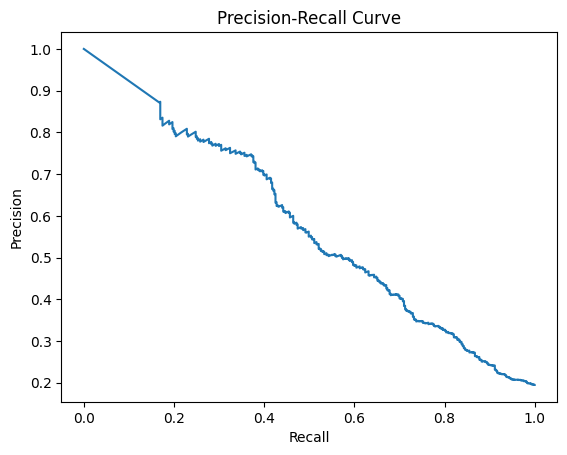

Optimal threshold for ~70% recall: 0.00
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1682
         1.0       0.19      1.00      0.33       407

    accuracy                           0.19      2089
   macro avg       0.10      0.50      0.16      2089
weighted avg       0.04      0.19      0.06      2089



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Get predicted probabilities for the test set
y_proba = qda.predict_proba(X_ads_test)[:, 1]

# Plot Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Find threshold to maximize recall (e.g., target 70% recall)
target_recall = 0.7
threshold = thresholds[np.argmax(recall >= target_recall)]
print(f"Optimal threshold for ~70% recall: {threshold:.2f}")

# Apply custom threshold
y_pred_tuned = (y_proba >= threshold).astype(int)
print(classification_report(y_test, y_pred_tuned))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train with class balancing
rf = RandomForestClassifier(
    class_weight={0: 1, 1: 10},  # Give more weight to attacks (class 1)
    random_state=42
)
rf.fit(X_ads_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_ads_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92      1682
         1.0       0.74      0.41      0.53       407

    accuracy                           0.86      2089
   macro avg       0.81      0.69      0.72      2089
weighted avg       0.85      0.86      0.84      2089



In [ ]:
from imblearn.over_sampling import SMOTE

# Resample the training data
smote = SMOTE(random_state=42)
X_ads_train_res, y_train_res = smote.fit_resample(X_ads_train, y_train)

# Retrain QDA on resampled data
qda_smote = QuadraticDiscriminantAnalysis()
qda_smote.fit(X_ads_train_res, y_train_res)

# Predict and evaluate
y_pred_smote = qda_smote.predict(X_ads_test)
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91      1682
         1.0       0.75      0.36      0.49       407

    accuracy                           0.85      2089
   macro avg       0.80      0.67      0.70      2089
weighted avg       0.84      0.85      0.83      2089

